In [23]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
from collections import defaultdict

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


Season 22018 contained 1230 games
teams scores
MIL: 0.08067309289350107
OKC: 0.07986952671719307
DEN: 0.07061526945190666
GSW: 0.06185231089450853
HOU: 0.05802384946362299
BOS: 0.05069400133241958
TOR: 0.04825766139017201
IND: 0.04730176015187283
SAS: 0.04701104623896485
UTA: 0.04650150022805409
POR: 0.0456384122817719
PHI: 0.0372098502389447
PHX: 0.03229200484142157
DAL: 0.029049756086343765
ORL: 0.028870995116662822
DET: 0.026654419262421694
LAC: 0.025394098024982766
MIN: 0.024154104371136388
MIA: 0.02119640294893094
BKN: 0.019973929932801473
SAC: 0.019038611972728863
CHA: 0.017772148457991976
MEM: 0.015335421666142983
NOP: 0.015313888138948017
LAL: 0.01457898796207979
ATL: 0.010348695160767484
WAS: 0.007783700628781589
CHI: 0.0073964078081799126
NYK: 0.00589009602468688
CLE: 0.005308050312058829


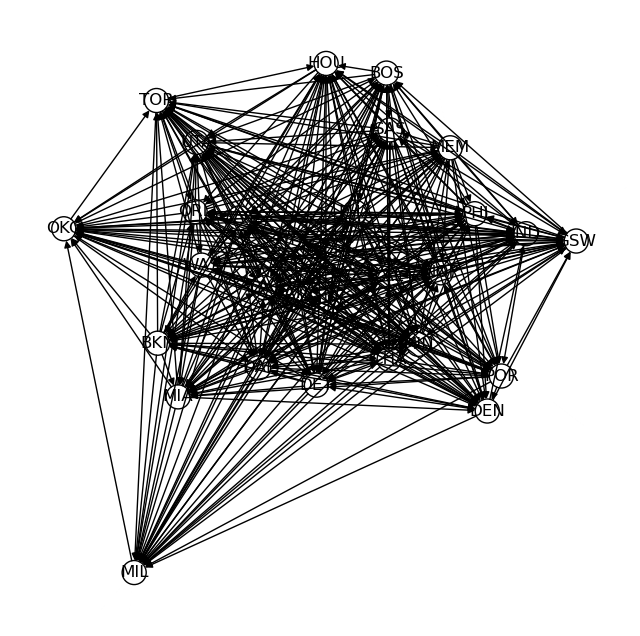

In [2]:
df = pd.read_csv("./nba/game.csv")
df.sort_values(by=["game_date"], inplace=True)

cond = df["team_abbreviation_home"] == "HOU"
cols = ["game_date", "matchup_home", "wl_home"]

grouped = df.groupby("season_id")
HOME = "team_abbreviation_home"
AWAY = "team_abbreviation_away"
for id_, season in grouped:
    if id_ not in [22018]: continue
    print(f"Season {id_} contained {len(season)} games")
    teams = set(season[HOME]) | set(season[AWAY])
    DG = nx.DiGraph()
    DG.add_nodes_from(teams)
    mapping = defaultdict(int)
    for index, game in season.iterrows():
        home_team = game[HOME]
        away_team = game[AWAY]
        pair = (home_team, away_team) if home_team < away_team else (away_team, home_team)
        pts_diff = game["plus_minus_home"] if home_team == pair[0] else game["plus_minus_away"]
        mapping[pair] += pts_diff
    i = 0
    for pair, diff in mapping.items():
        team_a, team_b = pair
        i += 1
        if diff < 0:
            # Team A lost against Team B: directed edge from A to B (loser -> winner)
            DG.add_edge(team_a, team_b, weight=abs(diff))
        else:
            # Team B lost against Team A: directed edge from B to A (loser -> winner)
            DG.add_edge(team_b, team_a, weight=diff)
    # print(f"Processed {i} edges")
    # print(dict(mapping))
    options = {
        "node_color": "none",
        "edgecolors": "black",
    }
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(DG, k=2)
    nx.draw_networkx(DG, pos, **options)
    # labels = nx.get_edge_attributes(DG, "weight")
    # nx.draw_networkx_edge_labels(DG, pos, edge_labels=labels)
    rank = nx.pagerank(DG)
    print("teams scores")
    for team, score in sorted(rank.items(), key=lambda item: item[1], reverse=True):
        print(f"{team}: {score}")
    plt.axis("off")
    plt.show()
    break

In [3]:
pagerank_df = pd.DataFrame(rank.items(), columns=['Team', 'PageRank_Score'])

# merge pagerank scores with game data
df = df.merge(pagerank_df, left_on='team_abbreviation_home', right_on='Team')
df.rename(columns={'PageRank_Score': 'PageRank_Home'}, inplace=True)
df.drop(columns=['Team'], inplace=True)

df = df.merge(pagerank_df, left_on='team_abbreviation_away', right_on='Team')
df.rename(columns={'PageRank_Score': 'PageRank_Away'}, inplace=True)
df.drop(columns=['Team'], inplace=True)

pagerank_df

,Team,PageRank_Score
0,MIL,0.080673
1,MEM,0.015335
2,LAL,0.014579
3,IND,0.047302
4,TOR,0.048258
5,ORL,0.028871
6,POR,0.045638
7,SAS,0.047011
8,PHX,0.032292
9,UTA,0.046502


In [4]:
# # define features (pagerank of both teams) and target (win/loss)
X = df[['PageRank_Home', 'PageRank_Away']]
y = (df['plus_minus_home'] > 0).astype(int)

# random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Model Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.47      0.19      0.27      3292
           1       0.63      0.86      0.73      5158

    accuracy                           0.60      8450
   macro avg       0.55      0.53      0.50      8450
weighted avg       0.57      0.60      0.55      8450



In [7]:
# Method from slides

# extract teams
teams = sorted(set(df["team_abbreviation_home"]).union(set(df["team_abbreviation_away"])))
team_index = {team: i for i, team in enumerate(teams)}

# initialize score matrix(S)
num_teams = len(teams)
S = np.zeros((num_teams, num_teams))  # S_ij = points team i scored on team j

# populate the score matrix from game data
for _, game in df.iterrows():
    home_idx = team_index[game["team_abbreviation_home"]]
    away_idx = team_index[game["team_abbreviation_away"]]

    S[home_idx, away_idx] += game["pts_home"]  # Home team points against Away
    S[away_idx, home_idx] += game["pts_away"]  # Away team points against Home

# initialize offense(O) and defense(D) ratings
O = np.ones(num_teams)
D = np.ones(num_teams)

# iterative solver for the ratings
max_iterations = 100
tolerance = 1e-6

for _ in range(max_iterations):
    O_new = np.sum(S / D, axis=1)  # update offense: sum of points scored, weighted by defenses faced
    D_new = np.sum(S.T / O, axis=1)  # update defense: sum of points allowed, weighted by offenses faced

    # normalize values to prevent scale explosion
    O_new /= np.mean(O_new)
    D_new /= np.mean(D_new)

    # check convergence
    if np.max(np.abs(O_new - O)) < tolerance and np.max(np.abs(D_new - D)) < tolerance:
        break

    O, D = O_new, D_new  # update values

# results df
od_df = pd.DataFrame({"Team": teams, "Offense_Score": O, "Defense_Score": D})
print(od_df.sort_values(by="Offense_Score", ascending=False))


   Team  Offense_Score  Defense_Score
2   BOS       1.467855       1.437532
13  LAL       1.405107       1.378818
19  NYK       1.300139       1.312781
8   DET       1.293278       1.300707
23  PHX       1.282174       1.269504
4   CHI       1.260169       1.259079
16  MIL       1.257927       1.251305
10  HOU       1.248902       1.240375
0   ATL       1.247174       1.258014
24  POR       1.220974       1.211998
5   CLE       1.182252       1.192067
7   DEN       1.181196       1.183873
29  WAS       1.150538       1.172387
11  IND       1.139651       1.138912
6   DAL       1.111828       1.107221
12  LAC       1.012233       1.027356
25  SAC       0.985445       1.004345
15  MIA       0.955523       0.951111
21  ORL       0.908218       0.916654
17  MIN       0.898037       0.915555
9   GSW       0.846561       0.839157
26  SAS       0.834502       0.805621
28  UTA       0.804429       0.787535
27  TOR       0.795808       0.795469
22  PHI       0.774316       0.783019
14  MEM     

In [9]:
team_A = "LAL"  # Los Angeles Lakers
team_B = "GSW"  # Golden State Warriors

# Get PageRank scores
pagerank_A = pagerank_df[pagerank_df['Team'] == team_A]['PageRank_Score'].values
pagerank_B = pagerank_df[pagerank_df['Team'] == team_B]['PageRank_Score'].values

# Get Offense & Defense scores
offense_A = od_df[od_df['Team'] == team_A]['Offense_Score'].values
defense_A = od_df[od_df['Team'] == team_A]['Defense_Score'].values
offense_B = od_df[od_df['Team'] == team_B]['Offense_Score'].values
defense_B = od_df[od_df['Team'] == team_B]['Defense_Score'].values

# Check if all values exist
if len(pagerank_A) == 0 or len(pagerank_B) == 0 or len(offense_A) == 0 or len(defense_A) == 0 or len(offense_B) == 0 or len(defense_B) == 0:
    print("Error: Missing team data for one or both teams.")
else:
    # Create input feature vector
    input_features = [[pagerank_A[0], pagerank_B[0], offense_A[0], defense_A[0], offense_B[0], defense_B[0]]]

    # Make prediction
    prediction = model.predict(input_features)

    # Interpret result
    winner = team_A if prediction[0] == 1 else team_B
    print(f"Predicted Winner: {winner}")


/Users/anikagarg/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 6 features, but RandomForestClassifier is expecting 2 features as input.

In [ ]:

df = pd.read_csv("./nba/game.csv")
df.sort_values(by=["game_date"], inplace=True)


grouped = df.groupby("season_id")
HOME = "team_abbreviation_home"
AWAY = "team_abbreviation_away"

season_df = None
for id_, season in grouped:
    if id_ != 22017:
        continue
    season_df = season.copy()
    break

teams = set(season_df[HOME]) | set(season_df[AWAY])
DG = nx.DiGraph()
DG.add_nodes_from(teams)
mapping = defaultdict(int)

for _, game in season_df.iterrows():
    home_team = game[HOME]
    away_team = game[AWAY]
    pair = (home_team, away_team) if home_team < away_team else (away_team, home_team)
    pts_diff = game["plus_minus_home"] if home_team == pair[0] else game["plus_minus_away"]
    mapping[pair] += pts_diff

for pair, diff in mapping.items():
    team_a, team_b = pair
    if diff < 0:
        DG.add_edge(team_a, team_b, weight=abs(diff))
    else:
        DG.add_edge(team_b, team_a, weight=diff)

pagerank = nx.pagerank(DG)
pagerank_df = pd.DataFrame(pagerank.items(), columns=['Team', 'PageRank_Score'])

df = df.merge(pagerank_df, left_on='team_abbreviation_home', right_on='Team')
df.rename(columns={'PageRank_Score': 'PageRank_Home'}, inplace=True)
df.drop(columns=['Team'], inplace=True)

df = df.merge(pagerank_df, left_on='team_abbreviation_away', right_on='Team')
df.rename(columns={'PageRank_Score': 'PageRank_Away'}, inplace=True)
df.drop(columns=['Team'], inplace=True)

teams = sorted(set(df[HOME]).union(set(df[AWAY])))
team_index = {team: i for i, team in enumerate(teams)}
num_teams = len(teams)
S = np.zeros((num_teams, num_teams))

for _, game in df.iterrows():
    home_idx = team_index[game[HOME]]
    away_idx = team_index[game[AWAY]]
    S[home_idx, away_idx] += game["pts_home"]
    S[away_idx, home_idx] += game["pts_away"]

O = np.ones(num_teams)
D = np.ones(num_teams)
max_iterations = 100
tolerance = 1e-6

for _ in range(max_iterations):
    O_new = np.sum(S / D, axis=1)
    D_new = np.sum(S.T / O, axis=1)
    O_new /= np.mean(O_new)
    D_new /= np.mean(D_new)
    if np.max(np.abs(O_new - O)) < tolerance and np.max(np.abs(D_new - D)) < tolerance:
        break
    O, D = O_new, D_new


od_df = pd.DataFrame({"Team": teams, "Offense_Score": O, "Defense_Score": D})


df = df.merge(od_df, left_on='team_abbreviation_home', right_on='Team')
df.rename(columns={'Offense_Score': 'Offense_Home', 'Defense_Score': 'Defense_Home'}, inplace=True)
df.drop(columns=['Team'], inplace=True)

df = df.merge(od_df, left_on='team_abbreviation_away', right_on='Team')
df.rename(columns={'Offense_Score': 'Offense_Away', 'Defense_Score': 'Defense_Away'}, inplace=True)
df.drop(columns=['Team'], inplace=True)


df["home_advantage"] = 1.3

# define new feature set
features = [
    'PageRank_Home', 'PageRank_Away',
    'Offense_Home', 'Defense_Home',
    'Offense_Away', 'Defense_Away',
    'home_advantage'
]

X = df[features]
y = (df['plus_minus_home'] > 0).astype(int)

# time-based train/test split using first 75% of the 2018 season to predict the last 25%
df_sorted = df.sort_values(by='game_date')
cutoff = int(len(df_sorted) * 0.75)
X_train = df_sorted.iloc[:cutoff][features]
y_train = (df_sorted.iloc[:cutoff]['plus_minus_home'] > 0).astype(int)
X_test = df_sorted.iloc[cutoff:][features]
y_test = (df_sorted.iloc[cutoff:]['plus_minus_home'] > 0).astype(int)

# train and eval
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print(report)


Model Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.42      0.19      0.26      4523
           1       0.57      0.81      0.67      6039

    accuracy                           0.54     10562
   macro avg       0.50      0.50      0.46     10562
weighted avg       0.51      0.54      0.49     10562



In [ ]:
# GradientBoosting Classifier
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print(report)

Model Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.43      0.11      0.18      4523
           1       0.57      0.89      0.70      6039

    accuracy                           0.56     10562
   macro avg       0.50      0.50      0.44     10562
weighted avg       0.51      0.56      0.47     10562



In [ ]:
# XGBoost
model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print(report)

Model Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.42      0.19      0.26      4523
           1       0.57      0.81      0.67      6039

    accuracy                           0.54     10562
   macro avg       0.50      0.50      0.47     10562
weighted avg       0.51      0.54      0.49     10562



/Users/anikagarg/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


df = pd.read_csv("./nba/game.csv")
df.sort_values(by=["game_date"], inplace=True)


df = df[df['season_id'].isin([22016, 22017, 22018])]


grouped = df.groupby("season_id")
HOME = "team_abbreviation_home"
AWAY = "team_abbreviation_away"
season_df = grouped.get_group(22018).copy()

teams = set(season_df[HOME]) | set(season_df[AWAY])
DG = nx.DiGraph()
DG.add_nodes_from(teams)
mapping = defaultdict(int)

for _, game in season_df.iterrows():
    home_team = game[HOME]
    away_team = game[AWAY]
    pair = (home_team, away_team) if home_team < away_team else (away_team, home_team)
    pts_diff = game["plus_minus_home"] if home_team == pair[0] else game["plus_minus_away"]
    mapping[pair] += pts_diff

for pair, diff in mapping.items():
    team_a, team_b = pair
    if diff < 0:
        DG.add_edge(team_a, team_b, weight=abs(diff))
    else:
        DG.add_edge(team_b, team_a, weight=diff)

pagerank = nx.pagerank(DG)
pagerank_df = pd.DataFrame(pagerank.items(), columns=['Team', 'PageRank_Score'])


df = df.merge(pagerank_df, left_on='team_abbreviation_home', right_on='Team')
df.rename(columns={'PageRank_Score': 'PageRank_Home'}, inplace=True)
df.drop(columns=['Team'], inplace=True)

df = df.merge(pagerank_df, left_on='team_abbreviation_away', right_on='Team')
df.rename(columns={'PageRank_Score': 'PageRank_Away'}, inplace=True)
df.drop(columns=['Team'], inplace=True)


teams = sorted(set(df[HOME]).union(set(df[AWAY])))
team_index = {team: i for i, team in enumerate(teams)}
num_teams = len(teams)
S = np.zeros((num_teams, num_teams))

for _, game in df.iterrows():
    home_idx = team_index[game[HOME]]
    away_idx = team_index[game[AWAY]]
    S[home_idx, away_idx] += game["pts_home"]
    S[away_idx, home_idx] += game["pts_away"]

O = np.ones(num_teams)
D = np.ones(num_teams)
max_iterations = 100
tolerance = 1e-6

for _ in range(max_iterations):
    O_new = np.sum(S / D, axis=1)
    D_new = np.sum(S.T / O, axis=1)
    O_new /= np.mean(O_new)
    D_new /= np.mean(D_new)
    if np.max(np.abs(O_new - O)) < tolerance and np.max(np.abs(D_new - D)) < tolerance:
        break
    O, D = O_new, D_new

od_df = pd.DataFrame({"Team": teams, "Offense_Score": O, "Defense_Score": D})


for side in ['home', 'away']:
    df = df.merge(od_df, left_on=f'team_abbreviation_{side}', right_on='Team')
    df.rename(columns={
        'Offense_Score': f'Offense_{side.capitalize()}',
        'Defense_Score': f'Defense_{side.capitalize()}'
    }, inplace=True)
    df.drop(columns=['Team'], inplace=True)


df['home_advantage'] = 1


features = [
    'PageRank_Home', 'PageRank_Away',
    'Offense_Home', 'Defense_Home',
    'Offense_Away', 'Defense_Away',
    'home_advantage'
]
df['target'] = (df['plus_minus_home'] > 0).astype(int)

# use 2016, 2017, and first 50% of 2018 for training
train_df = df[(df['season_id'].isin([22016, 22017])) | ((df['season_id'] == 22018) & (df.groupby('season_id').cumcount() < df[df['season_id'] == 22018].shape[0] * 0.5))]
test_df = df[(df['season_id'] == 22018) & (df.groupby('season_id').cumcount() >= df[df['season_id'] == 22018].shape[0] * 0.5)]

X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

# XGBoost model
model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print(report)


Model Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.43      0.38      0.40       228
           1       0.66      0.71      0.68       387

    accuracy                           0.58       615
   macro avg       0.54      0.54      0.54       615
weighted avg       0.57      0.58      0.58       615



/Users/anikagarg/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:50:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
